## 6. Notebook to reproduce Morphology graph summary plots
Notebook to reproduce Summary plots used in paper

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
import os
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy import interpolate
from scipy import optimize
from scipy import stats
import numpy as np
import rasterstats as rs
from statsmodels.nonparametric.smoothers_lowess import lowess
from datetime import datetime, timedelta
from datetime import date
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 3
#sns.set_style("dark")
mpl.rcParams.update({'font.size': 20})
from pylab import rcParams

np.seterr(divide='ignore', invalid='ignore')


def lowess_glac(data,column,days):
    
    X = data.DT.map(datetime.toordinal).to_list()
    Y = data[column].to_list()


    f = interpolate.interp1d(X,Y)
    xnew = list(np.arange(X[0], X[-1], days))
    ynew = list(f(xnew))   # use interpolation function returned by `interp1d
    interp = pd.DataFrame(ynew, index = xnew, columns=['interp'])
    interp = interp.dropna()
    x = interp.index.to_list()
    y = interp.interp.to_list()
    #2 year window
    filtered = lowess(y,x,frac=.06)
    interp['lowess'] = filtered[:,1]
    interp['DT']=interp.index.map(datetime.fromordinal)
    
    return interp


def verts(df):
    
    n_vertices=[] ###

    for i, row in df.iterrows():
        # It's better to check if multigeometry
        multi = row.geometry.type.startswith("Multi")

        if multi:
            n = 0
            # iterate over all parts of multigeometry
            for part in row.geometry:
                n += len(part.coords)
        else:
            n = len(row.geometry.coords)
        n_vertices.append(n) ###
    return n_vertices


from datetime import datetime, timedelta
from datetime import date

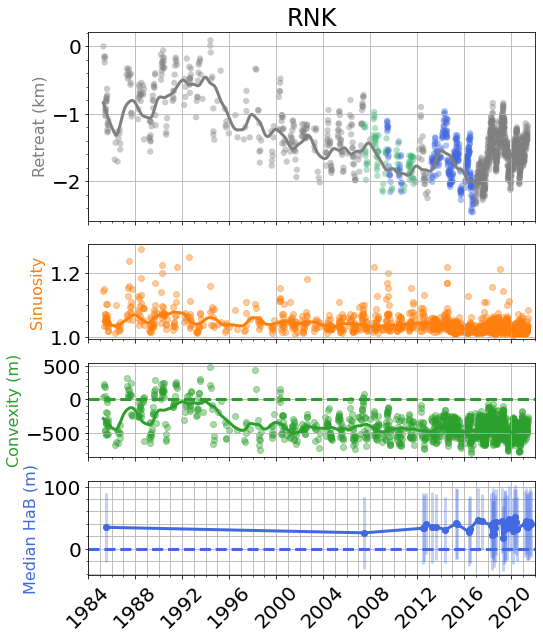

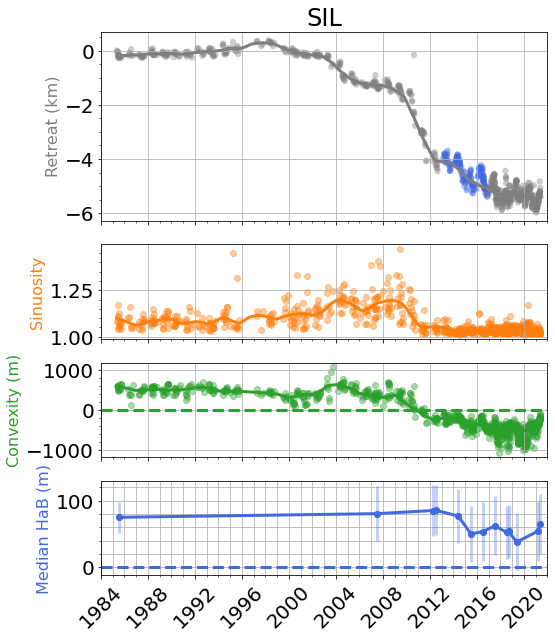

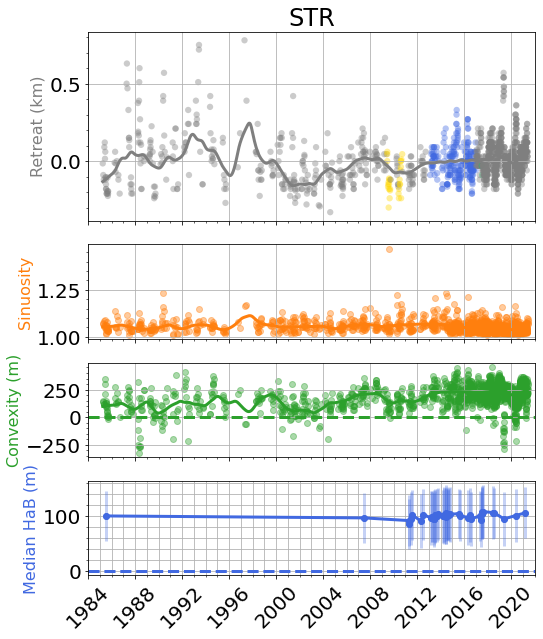

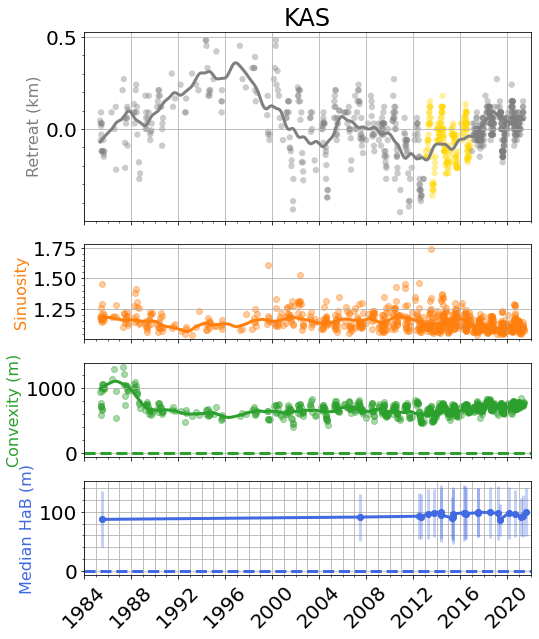

In [44]:
colors={'Buoyant Flexure':'royalblue', 'Serac Failure':'gold', 'Mixed':'mediumseagreen', '0' : 'tab:grey'}
    



for ids,name in zip([1,288,284,291],['RNK','SIL','STR','KAS']):
    #glac = gpd.read_file('morphology_termini/selected_glacs/'+str(ids)+'.shp')
    glac = pd.read_csv('morphology_termini/labed_termini/'+str(ids)+'.csv')
    glac['DT']=pd.to_datetime(glac['DT'])
    
    #glac=glac.groupby(['Date']).agg('mean')
    #glac['DT'] = pd.to_datetime(glac.index)
    glac=glac.sort_values(by=['DT'])

    #retreat = pd.read_csv('Terminus/Retreat/selected_glacs/'+str(ids)+'.csv')
    #retreat['retreat'] = retreat['retreat']/-1000
    #retreat['DT'] = pd.to_datetime(retreat.date)
    #retreat=retreat.groupby(['date']).agg('mean')
    #retreat=retreat.sort_index()

    #glac['retreat'] = retreat['retreat']

    sin_smooth = lowess_glac(glac,'sinuosity',7)
    ret_smooth = lowess_glac(glac,'retreat',7)
    con_smooth = lowess_glac(glac,'convexity',7)
    
    f, (a0, a1, a2, a3) = plt.subplots(4, 1, gridspec_kw={'height_ratios': [2,1, 1, 1]}, figsize = (8,10), sharex=True)
    
    #retreat
    a0.plot(ret_smooth.DT,ret_smooth.lowess,color='tab:grey')
    #a0.scatter(glac.DT,glac.retreat,color='tab:grey',alpha=0.3)
    sns.scatterplot(data=glac, x='DT',y='retreat', hue="label",ax=a0, legend=False, linewidth=0, s= 40,palette=colors, alpha = .4)
    a0.set_ylabel('Retreat (km)',color = 'tab:grey',fontsize=16)
    
    a0.set_title(name)
    
    #sinuosity
    a1.plot(sin_smooth.DT,sin_smooth.lowess,color='tab:orange')
    a1.scatter(glac.DT,glac.sinuosity,color='tab:orange',alpha=0.4)
    a1.set_ylabel('Sinuosity',color = 'tab:orange',fontsize=16)

    
    #convexity
    a2.plot(con_smooth.DT,con_smooth.lowess,color='tab:green')
    a2.scatter(glac.DT,glac.convexity,color='tab:green',alpha=0.4)
    a2.hlines(y=0, xmin = datetime(1984,1,1) , xmax =datetime(2023,1,1), linestyle = 'dashed', color = 'tab:green')

    a2.set_ylabel('Convexity (m)',color = 'tab:green',fontsize=16)

    #HAB
    hab = gpd.read_file('HAB_Sampled/'+str(ids)+'.shp')
    hab =hab[hab['DEM'] != 'SPOT_geoid']
    
    hab['DT'] = pd.to_datetime(hab['Date'])
    hab= hab.set_index('DT')
    hab= hab.sort_values(by='DT')
    #Height Above Bouyancy
    a3.plot(hab.index,hab['median'], '-o',color = 'royalblue')
    a3.errorbar(hab.index,hab['median'], yerr=hab['std'], fmt="o",color = 'royalblue', alpha=0.3)
    a3.hlines(y=0, xmin = datetime(1984,1,1) , xmax =datetime(2023,1,1), linestyle = 'dashed', color = 'royalblue')
    a3.set_xlim([datetime(1984,1,1),datetime(2022,1,1)])

    a3.set_ylabel('Median HaB (m)',color = 'royalblue',fontsize=16)
    plt.setp(a3.get_xticklabels(), rotation=45)
    
    a0.grid(which='major')
    #a0.grid(which='minor')
    a0.minorticks_on()
    
    a1.grid(which='major')
    #a1.grid(which='minor')
    a1.minorticks_on()
    
    a2.grid(which='major')
    #a2.grid(which='minor')
    a2.minorticks_on()
    
    a3.grid(which='major')
    a3.grid(which='minor')
    a3.minorticks_on()
    


    f.savefig('Figures/Paper/main/summary/'+str(ids)+'.png',  bbox_inches="tight")

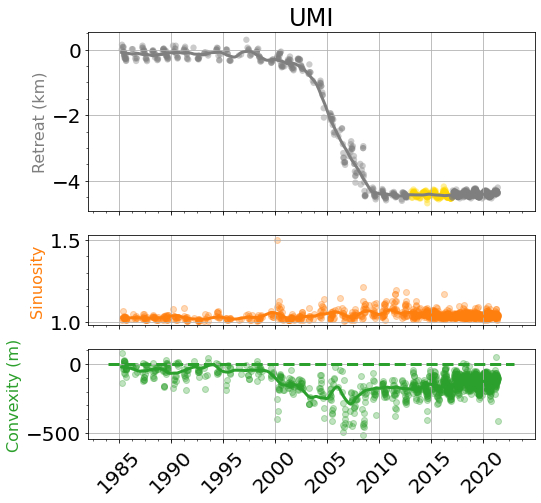

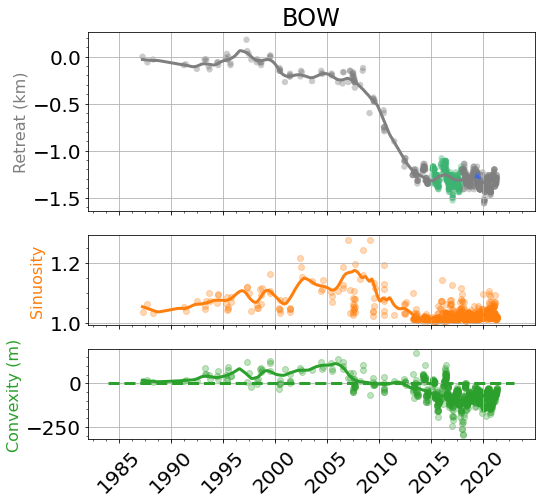

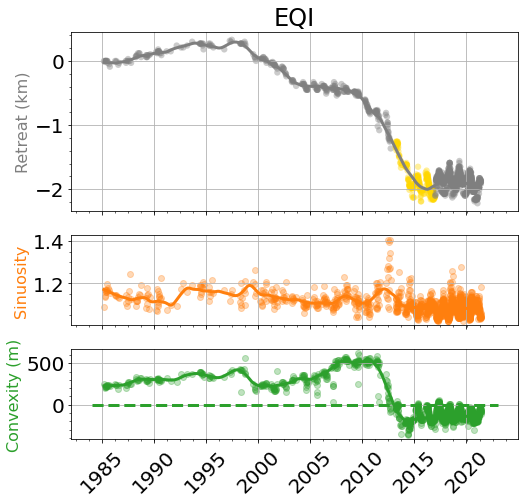

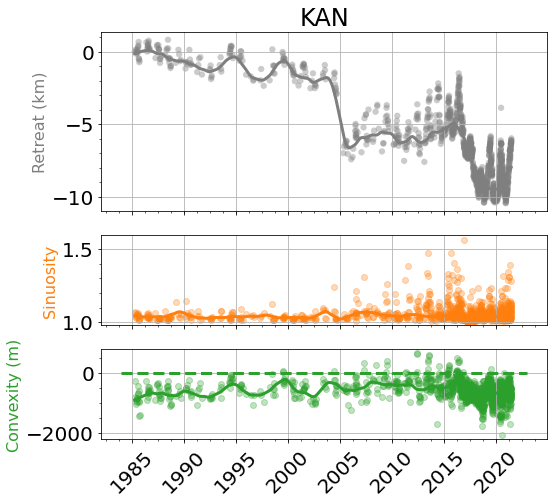

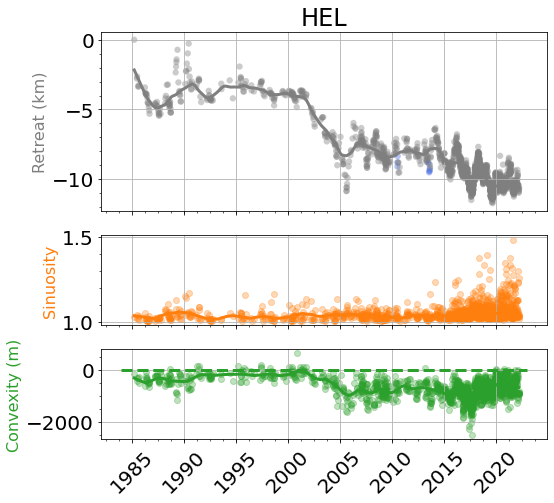

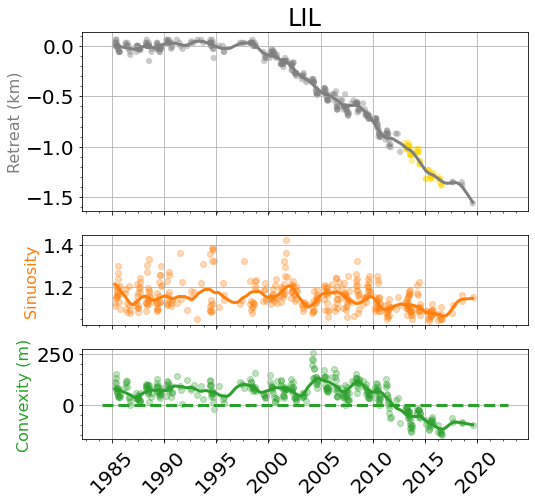

In [45]:
colors={'Buoyant Flexure':'royalblue', 'Serac Failure':'gold', 'Mixed':'mediumseagreen', '0' : 'tab:grey',0 : 'tab:grey'}
for ids,name in zip([2,77,280,152,181,285],['UMI','BOW','EQI','KAN','HEL','LIL']):
    
    #glac = gpd.read_file('morphology_termini/selected_glacs/'+str(ids)+'.shp')
    glac = pd.read_csv('morphology_termini/labed_termini/'+str(ids)+'.csv')
    glac['DT']=pd.to_datetime(glac['DT'])

    
    #glac=glac.groupby(['Date']).agg('mean')
    #glac['DT'] = pd.to_datetime(glac.index)
    glac=glac.sort_values(by=['DT'])

    #retreat = pd.read_csv('Terminus/Retreat/selected_glacs/'+str(ids)+'.csv')
    #retreat['retreat'] = retreat['retreat']/-1000
    #retreat['DT'] = pd.to_datetime(retreat.date)
    #retreat=retreat.groupby(['date']).agg('mean')
    #retreat=retreat.sort_index()

    #glac['retreat'] = retreat['retreat']

    sin_smooth = lowess_glac(glac,'sinuosity',7)
    ret_smooth = lowess_glac(glac,'retreat',7)
    con_smooth = lowess_glac(glac,'convexity',7)
    
    f, (a0, a1, a2) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [2,1, 1]}, figsize = (8,7.5), sharex=True)
    
    #retreat
    a0.plot(ret_smooth.DT,ret_smooth.lowess,color='tab:grey')
    #a0.scatter(glac.DT,glac.retreat,color='tab:grey',alpha=0.3)
    sns.scatterplot(data=glac, x='DT',y='retreat', hue="label",ax=a0, legend=False, linewidth=0, s= 40,palette=colors, alpha = .4)
    a0.set_ylabel('Retreat (km)',color = 'tab:grey',fontsize=16)
    
    a0.set_title(name)
    
    #sinuosity
    a1.plot(sin_smooth.DT,sin_smooth.lowess,color='tab:orange')
    a1.scatter(glac.DT,glac.sinuosity,color='tab:orange',alpha=0.3)
    a1.set_ylabel('Sinuosity',color = 'tab:orange',fontsize=16)

    
    #convexity
    a2.plot(con_smooth.DT,con_smooth.lowess,color='tab:green')
    a2.scatter(glac.DT,glac.convexity,color='tab:green',alpha=0.3)
    a2.hlines(y=0, xmin = datetime(1984,1,1) , xmax =datetime(2023,1,1), linestyle = 'dashed', color = 'tab:green')

    a2.set_ylabel('Convexity (m)',color = 'tab:green',fontsize=16)

    plt.setp(a2.get_xticklabels(), rotation=45)
    
    a0.grid(which='major')
    #a0.grid(which='minor')
    a0.minorticks_on()
    
    a1.grid(which='major')
    #a1.grid(which='minor')
    a1.minorticks_on()
    
    a2.grid(which='major')
    #a2.grid(which='minor')
    a2.minorticks_on()
    
    f.savefig('Figures/Paper/main/summary/'+str(ids)+'.png',  bbox_inches="tight")
